## Connor Contursi

# Configure Defaults

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Define paths to model files
import os

MY_PATH = "/DPL"
GDRIVE_PATH = "/content/drive/My Drive/DPL/"
GDRIVE_GARBO = "/content/drive/" + "MyDrive/" + "DPL/"
MODELS_DIR = GDRIVE_GARBO
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + "model"
MODEL_NO_QUANT_TFLITE = MODELS_DIR + "model_no_quant.tflite"
MODEL_TFLITE = MODELS_DIR + "model.tflite"
MODEL_TFLITE_MICRO = MODELS_DIR + "model.cc"

In [24]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras

# Numpy is a math library
import numpy as np

# Pandas is a data manipulation library
import pandas as pd

# Matplotlib is a graphing library
import matplotlib.pyplot as plt

# Math is Python's math library
import math

# SKlearn for reporting precision, recall, confusion matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

# Dataset

In [26]:
from tqdm import tqdm

path = "/content/drive/My Drive/Data"

# ----------------------------------------------------------------------------------

# Initializes individual data sets
class_up = pd.DataFrame()
class_down = pd.DataFrame()
class_stop = pd.DataFrame()
class_go = pd.DataFrame()
up_files = 0
down_files = 0
stop_files = 0
go_files = 0

# Strings used to open the correct files
up_match = "up"
down_match = "down"
stop_match = "stop"
go_match = "go"

# Counts all the files in a given directory.
initial_count = len(
    [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
)
dirre = os.listdir(path)
file_count = 2 * len(dirre)

# Iterates through the directory and compiles data for waves and fist bumps.
# Also displays a progress bar at the bottom which keeps track of work done.
with tqdm(total=file_count) as pbar:
    for subdir, dirs, files in os.walk(path):
        for file in files:
            os.chdir(subdir)

            # Checks for up audio file and then pulls data
            if up_match in file.lower():
                pbar.update(1)  # Increment the progress bar
                up_array = np.genfromtxt(
                    file,
                    delimiter=",",
                    dtype=np.float32,
                    usecols=range(64),
                    skip_header=1,
                )
                up_array = up_array.reshape(25, 64)
                up_data_array = pd.DataFrame(up_array)
                class_up = pd.concat([class_up, up_data_array])
                up_files += 1

            # Checks for down audio file and then pulls data
            if down_match in file.lower():
                pbar.update(1)  # Increment the progress bar
                down_array = np.genfromtxt(
                    file,
                    delimiter=",",
                    dtype=np.float32,
                    usecols=range(64),
                    skip_header=1,
                )
                down_array = down_array.reshape(25, 64)
                down_data_array = pd.DataFrame(down_array)
                class_down = pd.concat([class_down, down_data_array])
                down_files += 1

            # Checks for go audio file and then pulls data
            if go_match in file.lower():
                pbar.update(1)  # Increment the progress bar
                go_array = np.genfromtxt(
                    file,
                    delimiter=",",
                    dtype=np.float32,
                    usecols=range(64),
                    skip_header=1,
                )
                go_array = go_array.reshape(25, 64)
                go_data_array = pd.DataFrame(go_array)
                class_go = pd.concat([class_go, go_data_array])
                go_files += 1

            # Checks for stop audio file and then pulls data
            if stop_match in file.lower():
                pbar.update(1)  # Increment the progress bar
                stop_array = np.genfromtxt(
                    file,
                    delimiter=",",
                    dtype=np.float32,
                    usecols=range(64),
                    skip_header=1,
                )
                stop_array = stop_array.reshape(25, 64)
                stop_data_array = pd.DataFrame(stop_array)
                class_stop = pd.concat([class_stop, stop_data_array])
                stop_files += 1

pbar.close()

# Combines all of class data for wave and fistbumps into single set
class_data = pd.concat([class_up, class_down, class_go, class_stop])
samples, unused_y = class_data.shape
asserts = samples * unused_y
# ----------------------------------------------------------------------------------

# Creates y labels
# Combines all of class data for wave and fistbumps into single set
class_data = pd.concat([class_up, class_down, class_go, class_stop])

# Creates y labels
y = np.zeros((up_files + down_files + go_files + stop_files) * 25)
for a in range (up_files * 25, (up_files + down_files) * 25, 1):
    y[a] = 1
for b in range ((up_files + down_files) * 25, (up_files + down_files + go_files) * 25, 1):
    y[b] = 2
for c in range ((up_files + down_files + go_files) * 25, (up_files + down_files + go_files + stop_files) * 25, 1):
    y[c] = 3

y = y.astype(np.float32)

76it [00:00, 191.45it/s]


## Splitting Data

In [27]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT = int(0.6 * samples)
TEST_SPLIT = int(0.2 * samples + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(class_data, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) == asserts

# Design the Model

In [28]:
# We'll use Keras to create a simple model architecture
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 8 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(keras.layers.Dense(128, activation="relu", input_shape=(x_train.shape[1],)))

# Final layer is a single neuron, since we want to output a single value
model_1.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer="adam", loss="mse", metrics=["mae"])

## Train the Model

In [29]:
history_1 = model_1.fit(
    x_train,
    y_train,
    epochs=500,
    batch_size=64,
    validation_data=(x_validate, y_validate),
)

Epoch 1/500
18/18 [==============================] - 1s 14ms/step - loss: 228.7417 - mae: 9.5876 - val_loss: 101.7264 - val_mae: 6.4585
Epoch 2/500
18/18 [==============================] - 0s 4ms/step - loss: 62.7582 - mae: 4.9846 - val_loss: 63.8342 - val_mae: 4.8807
Epoch 3/500
18/18 [==============================] - 0s 4ms/step - loss: 24.6879 - mae: 3.2696 - val_loss: 55.9121 - val_mae: 4.6741
Epoch 4/500
18/18 [==============================] - 0s 4ms/step - loss: 17.0500 - mae: 2.7560 - val_loss: 46.4599 - val_mae: 4.4601
Epoch 5/500
18/18 [==============================] - 0s 4ms/step - loss: 13.0293 - mae: 2.4046 - val_loss: 39.9370 - val_mae: 4.2934
Epoch 6/500
18/18 [==============================] - 0s 4ms/step - loss: 10.1751 - mae: 2.1521 - val_loss: 37.2776 - val_mae: 4.3843
Epoch 7/500
18/18 [==============================] - 0s 5ms/step - loss: 8.1391 - mae: 1.9860 - val_loss: 33.3749 - val_mae: 4.2214
Epoch 8/500
18/18 [==============================] - 0s 5ms/step - 

# Plotting the Metrics

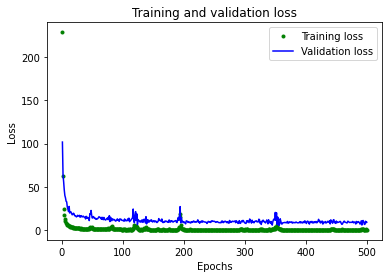

In [30]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history["loss"]
val_loss = history_1.history["val_loss"]

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, "g.", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

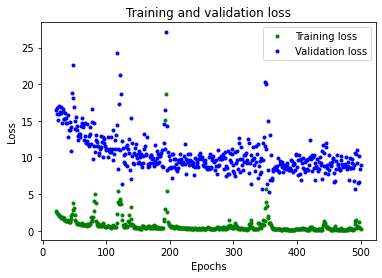

In [31]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 20

plt.plot(epochs[SKIP:], train_loss[SKIP:], "g.", label="Training loss")
plt.plot(epochs[SKIP:], val_loss[SKIP:], "b.", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Larger Model

In [32]:
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(keras.layers.Dense(16, activation="relu", input_shape=(x_train.shape[1],)))

# The new second and third layer will help the network learn more complex representations
model.add(keras.layers.Dense(16, activation="relu"))

# Final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [33]:
# Train the model
history = model.fit(
    x_train,
    y_train,
    epochs=500,
    batch_size=64,
    validation_data=(x_validate, y_validate),
)


# Save the model to disk
model.save(MODEL_TF)

Epoch 1/500
18/18 [==============================] - 2s 41ms/step - loss: 58.7123 - mae: 4.7609 - val_loss: 36.6438 - val_mae: 4.6488
Epoch 2/500
18/18 [==============================] - 0s 8ms/step - loss: 15.6287 - mae: 2.6394 - val_loss: 19.5252 - val_mae: 3.1445
Epoch 3/500
18/18 [==============================] - 0s 7ms/step - loss: 9.8962 - mae: 2.1143 - val_loss: 20.0289 - val_mae: 3.4387
Epoch 4/500
18/18 [==============================] - 0s 8ms/step - loss: 7.5650 - mae: 1.8838 - val_loss: 15.7439 - val_mae: 2.9788
Epoch 5/500
18/18 [==============================] - 0s 8ms/step - loss: 6.2321 - mae: 1.7067 - val_loss: 14.9008 - val_mae: 2.9930
Epoch 6/500
18/18 [==============================] - 0s 12ms/step - loss: 5.2578 - mae: 1.5966 - val_loss: 14.0045 - val_mae: 2.9242
Epoch 7/500
18/18 [==============================] - 0s 6ms/step - loss: 4.6125 - mae: 1.5086 - val_loss: 12.8585 - val_mae: 2.8317
Epoch 8/500
18/18 [==============================] - 0s 8ms/step - loss:

## Precision, Recall, F1 Score

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       0.0
         1.0       0.00      0.00      0.00       0.0
         2.0       0.00      0.00      0.00     285.0
         3.0       0.00      0.00      0.00      95.0

    accuracy                           0.00     380.0
   macro avg       0.00      0.00      0.00     380.0
weighted avg       0.00      0.00      0.00     380.0



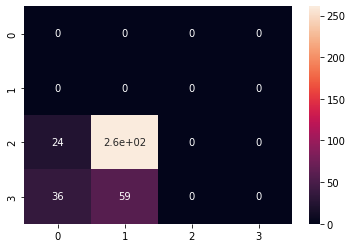

In [40]:
train_acc = model.evaluate(x_train, y_train, verbose=0)
test_acc = model.evaluate(x_test, y_test, verbose=0)

y_probs = model.predict(x_test, verbose=0)
y_classes = (model.predict(x_test) > 0.5).astype("int32")

y_probs = y_probs[:, 0]
y_classes = y_classes[:, 0]

# accuracy = accuracy_score(y_test, y_classes)
# precision = precision_score(y_test, y_classes)
# recall = recall_score(y_test, y_classes)
# f1 = f1_score(y_test, y_classes)

matrix = confusion_matrix(y_test, y_classes)
print(metrics.classification_report(y_test, y_classes))

f = sns.heatmap(matrix, annot=True)

## Plotting the Metrics

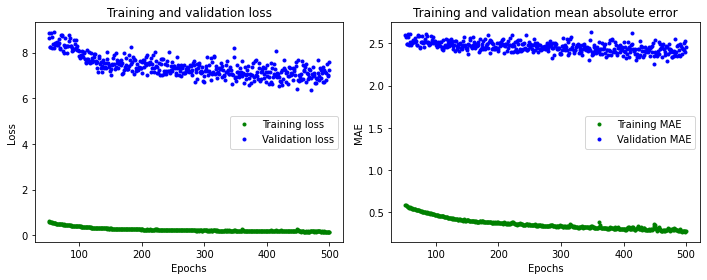

In [41]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 50

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], "g.", label="Training loss")
plt.plot(epochs[SKIP:], val_loss[SKIP:], "b.", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history["mae"]
val_mae = history.history["val_mae"]

plt.plot(epochs[SKIP:], train_mae[SKIP:], "g.", label="Training MAE")
plt.plot(epochs[SKIP:], val_mae[SKIP:], "b.", label="Validation MAE")
plt.title("Training and validation mean absolute error")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()

12/12 [==============================] - 0s 1ms/step - loss: 2.7003 - mae: 1.3211


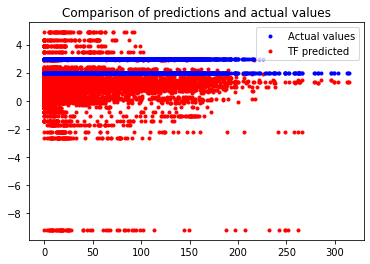

In [42]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

x_test = np.asarray(x_test).astype(int)
y_test = np.asarray(y_test).astype(int)

# y_test = np.array(y_test)
# #y_test_pred.to_numpy()
# Graph the predictions against the actual values
plt.clf()
plt.title("Comparison of predictions and actual values")
by = plt.plot(x_test, y_test_pred, "r.", label="TF predicted")
bx = plt.plot(x_test, y_test, "b.", label="Actual values")
plt.legend(handles=[bx[0], by[0]])
plt.show()

## Generating a TensorFlow Lite Model

In [44]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()
x_train.to_numpy().flatten()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
    for i in range(64):

        yield [x_train[i]]


# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

3760

## Compare Model Performance

In [47]:
def predict_tflite(tflite_model, x_test):
    # Prepare the test data
    x_test = x_test.flatten()
    x_test_ = x_test.copy()
    x_test_ = x_test_.reshape((380, 64))
    x_test_ = x_test_.astype(np.float32)

    # Initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # If required, quantize the input layer (from float to integer)
    input_scale, input_zero_point = input_details["quantization"]
    if (input_scale, input_zero_point) != (0.0, 0):
        x_test_ = x_test_ / input_scale + input_zero_point
        x_test_ = x_test_.astype(input_details["dtype"])

    # Invoke the interpreter
    y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
    for i in range(len(x_test_)):
        interpreter.set_tensor(input_details["index"], [x_test_[i]])
        interpreter.invoke()
        y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

    # If required, dequantized the output layer (from integer to float)
    output_scale, output_zero_point = output_details["quantization"]
    if (output_scale, output_zero_point) != (0.0, 0):
        y_pred = y_pred.astype(np.float32)
        y_pred = (y_pred - output_zero_point) * output_scale

    return y_pred


def evaluate_tflite(tflite_model, x_test, y_true):
    global model
    y_pred = predict_tflite(tflite_model, x_test)
    loss_function = tf.keras.losses.get(model.loss)
    loss = loss_function(y_true, y_pred).numpy()
    return loss

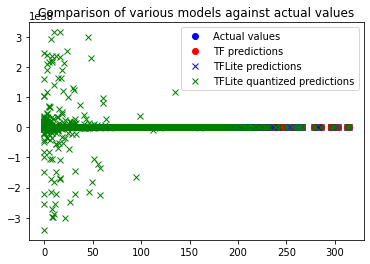

In [48]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)

y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

# Compare predictions

x_test = np.asarray(x_test).astype(int)
y_test = np.asarray(y_test).astype(int)
y_test_pred_no_quant_tflite = y_test_pred_no_quant_tflite.reshape(380, 64)
y_test_pred_tflite = y_test_pred_tflite.reshape(380, 64)

plt.title("Comparison of various models against actual values")
ax = plt.plot(x_test, y_test, "bo", label="Actual values")
ay = plt.plot(x_test, y_test_pred_tf, "ro", label="TF predictions")
aq = plt.plot(x_test, y_test_pred_no_quant_tflite, "bx", label="TFLite predictions")
az = plt.plot(x_test, y_test_pred_tflite, "gx", label="TFLite quantized predictions")

plt.legend(handles=[ax[0], ay[0], aq[0], az[0]])

plt.show()

### Size

In [49]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [50]:
# Compare size
pd.DataFrame.from_records(
    [
        ["TensorFlow", f"{size_tf} bytes", ""],
        [
            "TensorFlow Lite",
            f"{size_no_quant_tflite} bytes ",
            f"(reduced by {size_tf - size_no_quant_tflite} bytes)",
        ],
        [
            "TensorFlow Lite Quantized",
            f"{size_tflite} bytes",
            f"(reduced by {size_no_quant_tflite - size_tflite} bytes)",
        ],
    ],
    columns=["Model", "Size", ""],
    index="Model",
)

,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow Lite,6964 bytes,(reduced by -2868 bytes)
TensorFlow Lite Quantized,3760 bytes,(reduced by 3204 bytes)


## Generating a TensorFlow Lite Model for Microcontrollers

In [51]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i "s/model/g_model/" {MODEL_TFLITE_MICRO}

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad